In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()
using Plots
using Test
include("car.jl");
using ForwardDiff

  Activating environment at `~/convoy_ws/Project.toml`
  Activating environment at `~/convoy_ws/Project.toml`


In [208]:
# Define the model
model = BicycleModel()

# get the number of states and controls
n = state_dim(model)
m = control_dim(model)

# Evaluate the continuous and discrete dynamics
x0 = SA[0.,0.,0.,0.]
u0 = SA[0.,0.]
t0 = 0.0
dt = 0.025
dynamics(model, x0, u0)
discrete_dynamics(RK4, model, x0, u0, t0, dt)  # use rk4 for integration

# Evaluate the continuous and discrete Jacobians
z0 = KnotPoint(x0,u0,dt,t0)   # create a `KnotPoint` type that stores everything together
∇f = RobotDynamics.DynamicsJacobian(model)
jacobian!(∇f, model, z0)
discrete_jacobian!(RK4, ∇f, model, z0)

# Extract pieces of the Jacobian
A = ∇f.A
B = ∇f.B;

In [209]:
nx = n
nu = m

Q = Diagonal([1,1,1e-2,1e-2])
R = Diagonal([1e-1,1e-1])
Qf = Diagonal([1,1,1,1.])*10

N = 401
Nmpc = 80
Nhz = 10
delta = 100
Nc = N + 2*delta

FD = ForwardDiff;

In [232]:
function get_path()
    x1ref = zeros(Nc)*NaN
    x2ref = zeros(Nc)*NaN
    θref = zeros(Nc)*NaN
    v1ref = zeros(Nc)*NaN
    v2ref = zeros(Nc)*NaN
    ωref = zeros(Nc)*NaN
    rad = 20
    
    u1ref = zeros(Nc-1)*NaN
    u2ref = zeros(Nc-1)*NaN
    
    for i = 1:Nc
        θref[i] = 2*pi*(i-Nc)/(Nc-1)
        x1ref[i] = rad * sin(θref[i])
        x2ref[i] = rad - rad * cos(θref[i])
    end
    
    for i = 1:Nc-1
        v1ref[i] = 0.0
        u1ref[i] = sqrt((x1ref[i+1] - x1ref[i])^2 + (x2ref[i+1] - x2ref[i])^2)/dt
        u2ref[i] = 0.0
    end
    v1ref[1] = 0.0
    v1ref[Nc] = v1ref[Nc-1]
    
    xref = [x1ref'; x2ref'; θref'; v1ref']
    uref = [u1ref'; u2ref']
    return [x for x in eachcol(xref)], [u for u in eachcol(uref)]
end

get_path (generic function with 1 method)

In [233]:
# Plot the reference trajectory and compare with the given plot
Xref, Uref = get_path()

# convert to static arrays and plot
Xref = [SVector{4}(Xref[i]) for i = 1:length(Xref)]
tref = SA[0:dt:(Nc-1-2*delta)*dt]
trefu = SA[0:dt:(Nc-2-2*delta)*dt]

Uref = [SVector{2}(Uref[i]) for i = 1:length(Uref)];

## The Reference Trajectory
In this problem we'll be tracking a reference trajectory generated via trajectory optimization. The code below loads the reference trajectory, plots it using `Plots.jl` (and some custom plotting recipes in `RobotDynamics`) and visualizes it using MeshCat.

In [212]:
Q = Diagonal([10,10,10,1.])
R = Diagonal([1.,1.])
Qf = Diagonal([1,1,1,1.])*1;

In [213]:
function stage_cost(x,u,xref,uref, Q, R, Qf)
    # LQR cost at each knot point (depends on both x and u)
    J = 0.5 * (x - xref)' * Q * (x - xref) + 0.5 * (u - uref)' * R * (u - uref)
    
    return J
end

function term_cost(x,xref, Q, R, Qf)
    # LQR terminal cost (depends on just x)
    J = 0.5 * (x - xref)' * Qf * (x - xref)
    
    return J
end

function trajectory_cost(X,U,Xref,Uref, Q, R, Qf, Nmpc)
    # calculate the cost of a given trajectory 
    J = 0.0
    for i = 1:Nmpc-1
        J += stage_cost(X[i],U[i],Xref[i],Uref[i], Q, R, Qf)
    end
    J += term_cost(X[end], Xref[end], Q, R, Qf)
    
    return J
end
        
function stage_cost_expansion(x,u,xref,uref, Q, R, Qf, Nmpc)
    # if the stage cost function is J, return the following derivatives:
    # ∇²ₓJ,  ∇ₓJ, ∇²ᵤJ, ∇ᵤJ
    Jxx = Q
    Jx = Q * (x - xref)
    Juu = R
    Ju = R * (u - uref)
    
    return Jxx, Jx, Juu, Ju
end

function term_cost_expansion(x,xref, Q, R, Qf, Nmpc)
    # if the terminal cost function is J, return the following derivatives:
    # ∇²ₓJ,  ∇ₓJ
    Jxx = Qf
    Jx = Qf * (x - xref)
    
    return Jxx, Jx
end

term_cost_expansion (generic function with 1 method)

In [214]:
function dynamics_jacobians(x,u,dt)
    # returns the discrete time dynamics jacobians
    A = FD.jacobian(_x -> discrete_dynamics(RK4, model, _x, u, t0, dt),x)
    B = FD.jacobian(_u -> discrete_dynamics(RK4, model, x, _u, t0, dt),u)
    return A,B
end

dynamics_jacobians (generic function with 1 method)

In [215]:
function backward_pass(X,U,Xref,Uref, Q, R, Qf, Nmpc)

    # allocate all our data
    P = [zeros(nx,nx) for i = 1:Nmpc]     # cost to go quadratic term
    p = [zeros(nx) for i = 1:Nmpc]        # cost to go linear term 
    d = [zeros(nu)*NaN for i = 1:Nmpc-1]  # feedforward control
    K = [zeros(nu,nx) for i = 1:Nmpc-1]   # feedback gain
    ΔJ = 0.0                           # expected cost decrease
    
    P[Nmpc], p[Nmpc] = term_cost_expansion(X[Nmpc],Xref[Nmpc], Q, R, Qf, Nmpc)
    for i in reverse(1:Nmpc-1)
        A, B = dynamics_jacobians(X[i],U[i],dt)
        lxx, lx, luu, lu = stage_cost_expansion(X[i],U[i],Xref[i],Uref[i], Q, R, Qf, Nmpc)
        gx = lx + A'*p[i+1]
        gu = lu + B'*p[i+1]
        Gxx = lxx + A'*P[i+1]*A
        Guu = luu + B'*P[i+1]*B
        Gxu = A'*P[i+1]*B
        Gux = B'*P[i+1]*A
        d[i] = inv(Guu)*gu
        K[i] = inv(Guu)*Gux
        P[i] = Gxx + K[i]'*Guu*K[i] - Gxu*K[i] - K[i]'*Gux
        p[i] = gx - K[i]'*gu + K[i]'Guu*d[i] - Gxu*d[i]
        ΔJ += gu'*d[i]
    end
    
    return d, K, P, ΔJ
end

backward_pass (generic function with 1 method)

In [216]:
function forward_pass(X,U,Xref,Uref,K,d,ΔJ, Q, R, Qf, Nmpc; max_linesearch_iters = 100)
    
    Xn = deepcopy(X)
    Un = deepcopy(U)
    Jn = trajectory_cost(Xn,Un,Xref,Uref, Q, R, Qf, Nmpc)
    J = trajectory_cost(X,U,Xref,Uref, Q, R, Qf, Nmpc)
    α = 2
    iters = 0
    
    while Jn >= J - 0.002*α*ΔJ && iters < max_linesearch_iters
        α *= 0.5
        Xn = deepcopy(X)
        Un = deepcopy(U)
        for i = 1:Nmpc-1
            Un[i] = U[i] - α*d[i] - K[i]*(Xn[i]-X[i])
            Xn[i+1] = discrete_dynamics(RK4, model, Xn[i], Un[i], t0, dt)
        end
        J = trajectory_cost(X,U,Xref,Uref, Q, R, Qf, Nmpc)
        Jn = trajectory_cost(Xn,Un,Xref,Uref, Q, R, Qf, Nmpc)
        iters += 1
    end
        
    return Xn, Un, Jn, α
end

forward_pass (generic function with 1 method)

In [217]:
function iLQR(x0,U,Xref,Uref, Q, R, Qf, Nmpc;atol=0.3,max_iters = 40,verbose = true)
    X = [x0 for i = 1:Nmpc]
    U = U
    K = [zeros(nu,nx)*NaN for i = 1:Nmpc-1]
    P = [zeros(nx,nx)*NaN for i = 1:Nmpc]
    iter = -1
    max_norm = 10000
    
    while(iter < max_iters && max_norm > atol)
        d, K, P, ΔJ = backward_pass(X,U,Xref,Uref, Q, R, Qf, Nmpc)
        X, U, Jr, α = forward_pass(X,U,Xref,Uref,K,d,ΔJ, Q, R, Qf, Nmpc)
        iter += 1
        max_norm = max(norm(d))
    end

    return X,U,K,P,iter

end

iLQR (generic function with 1 method)

In [218]:
function get_closest_index(x, Xref)
    min_val = 1000000
    min_idx = 0
    for i = 1:length(Xref)
        x2 = Xref[i]
        dist = sqrt((x[1]-x2[1])^2 + (x[2]-x2[2])^2 + 10*(x[3]-x2[3])^2)
        if dist < min_val
            min_val = dist
            min_idx = i
        end
    end
    return min_idx
end

function getXUmpc(x, u, Xref, Uref, i, Nhz, Nmpc, Nc)
    k = get_closest_index(x, Xref)
    if i-k > 0.5*Nc
        k = Nc
    end
    Xrefmpc = [SVector{4}(Xref[j]) for j = k:min(Nmpc+k, Nc)]
    Urefmpc = [SVector{2}(Uref[j]) for j = k:min(Nmpc+k, Nc)-1]
    U0ref = [SVector{2}(u) for j = k:Nmpc+k-1]
    append!(Urefmpc, [SVector{2}([0., 0.]) for j = min(Nmpc, Nc-k):Nmpc-1])
    append!(Xrefmpc, [SVector{4}(Xref[end]) for j = min(Nmpc, Nc-k):Nmpc])
    Xrefmpc[1] = x
    Urefmpc[1] = u
   
    return Xrefmpc, Urefmpc, U0ref
end

function getFollowerX(XLast, Xref, gap_idx, Nmpc, Nc)
    idx = Int64(min(get_closest_index(XLast, Xref) + gap_idx, Nc))
    return [SVector{4}(Xref[idx]) for j = 1:Nmpc+2]
end

function getLeaderX(XLast, Xref, gap_idx, Nmpc, Nc)
    idx = Int64(max(get_closest_index(XLast, Xref) - gap_idx, 1))
    return [SVector{4}(Xref[idx]) for j = 1:Nmpc+2]
end

getLeaderX (generic function with 1 method)

In [248]:
function ilqr_mpc(Xref, Uref, start, Q, R, Qf, Nhz, Nmpc, Nc)
    Xline = []
    Uline = []
    XLast = Xref[start]
    ULast = Uref[start]
    for i = start:Nhz:Nc-1
        Xrefmpc, Urefmpc, U0ref = getXUmpc(XLast, ULast, Xref, Uref, i, Nhz, Nmpc, Nc)
        Xmpc,Umpc,Kmpc,Pmpc, itermpc = iLQR(Xrefmpc[1],U0ref,Xrefmpc,Urefmpc, Q, R, Qf, Nmpc)
        append!(Xline, Xmpc[1:Nhz])
        append!(Uline, Umpc[1:Nhz])
        XLast = Xmpc[Nhz+1]
        ULast = Umpc[Nhz+1]
    end
    return Xline, Uline
end

function ilqr_mpc_3(Xref, Uref, start, Q, R, Qf, Nhz, Nmpc, Nc, delta, bots)
    wt_f = 5
    wt_l = 5
    wt_traj = 5
#     Xline1 = []
#     Uline1 = []
#     Xline2 = []
#     Uline2 = []
#     Xline3 = []
#     Uline3 = []
    
    XLast = [SVector{4}(Xref[start+(bots-(k-1))*delta]) for k=1:bots]
    ULast = [SVector{2}(Uref[start+(bots-(k-1))*delta]) for k=1:bots]
    XLast1 = [SVector{4}(Xref[start+(bots-(k-1))*delta]) for k=1:bots]
    ULast1 = [SVector{2}(Uref[start+(bots-(k-1))*delta]) for k=1:bots]
    Xline = [copy(Xref) for k=1:bots]
    Uline = [copy(Uref) for k=1:bots]
    gap_idx = delta/2
    for i = start:Nhz:Nc-1
        
        for k = 1:bots
            
            Xrefmpc, Urefmpc, U0ref = getXUmpc(XLast[k], ULast[k], Xref, Uref, i+(k-1)*delta, Nhz, Nmpc, Nc)
#             @show Xrefmpc[1], XLast[k]
            
            if k == 1
                Xf = getFollowerX(XLast[k+1], Xref, gap_idx, Nmpc, Nc)
                Xrefc = (wt_traj*Xrefmpc + wt_f*Xf) / (wt_traj+wt_f)
            elseif k == bots
                Xl = getLeaderX(XLast[k-1], Xref, gap_idx, Nmpc, Nc)
                Xrefc = (wt_traj*Xrefmpc + wt_l*Xl) / (wt_traj+wt_l)
            else
                Xf = getFollowerX(XLast[k+1], Xref, gap_idx, Nmpc, Nc)
                Xl = getLeaderX(XLast[k-1], Xref, gap_idx, Nmpc, Nc)
                Xrefc = (wt_traj*Xrefmpc + wt_f*Xf + wt_l*Xl) / (wt_traj+wt_f+wt_l)
            end
            
            Xmpc,Umpc,Kmpc,Pmpc,itmpc = iLQR(Xrefmpc[1],U0ref,Xrefc,Urefmpc, Q, R, Qf, Nmpc)
            Xline[k][i:i+Nhz-1] = Xmpc[1:Nhz]
            Uline[k][i:i+Nhz-1] = Umpc[1:Nhz]
            XLast1[k] = Xmpc[Nhz+1]
            ULast1[k] = Umpc[Nhz+1]
        end
        
        XLast = XLast1
        ULast = ULast1
#         @show XLast[1]
        
        
        
#         Xrefmpc1, Urefmpc1, U0ref1 = getXUmpc(XLast[1], ULast[1], Xref, Uref, i, Nhz, Nmpc, Nc)
#         Xref1 = Xrefmpc1
#         Xb1 = getFollowerX(XLast[2], Xref, gap_idx, Nmpc, Nc)
#         Xref1 = 0.5*Xrefmpc1 + 0.5*Xb1
#         Xmpc1,Umpc1,Kmpc1,Pmpc1, itermpc1 = iLQR(Xrefmpc1[1],U0ref1,Xref1,Urefmpc1, Q, R, Qf, Nmpc)
        
#         Xrefmpc2, Urefmpc2, U0ref2 = getXUmpc(XLast[2], ULast[2], Xref, Uref, i+delta, Nhz, Nmpc, Nc)
#         Xref2 = Xrefmpc2
#         Xb2 = getFollowerX(XLast[3], Xref, gap_idx, Nmpc, Nc)
#         Xf2 = getLeaderX(XLast[1], Xref, gap_idx, Nmpc, Nc)
#         Xref2 = Xrefmpc2/3 + Xb2/3 + Xf2/3
#         Xmpc2,Umpc2,Kmpc2,Pmpc2, itermpc2 = iLQR(Xrefmpc2[1],U0ref2,Xref2,Urefmpc2, Q, R, Qf, Nmpc)
        
#         Xrefmpc3, Urefmpc3, U0ref3 = getXUmpc(XLast[3], ULast[3], Xref, Uref, i+2*delta, Nhz, Nmpc, Nc)
#         Xref3 = Xrefmpc3
#         Xf3 = getLeaderX(XLast[2], Xref, gap_idx, Nmpc, Nc)
#         Xref3 = 0.2*Xrefmpc1 + 0.8*Xf3
#         Xmpc3,Umpc3,Kmpc3,Pmpc3, itermpc3 = iLQR(Xrefmpc3[1],U0ref3,Xref3,Urefmpc3, Q, R, Qf, Nmpc)
        
#         append!(Xline1, Xmpc1[1:Nhz])
#         append!(Uline1, Umpc1[1:Nhz])
#         XLast[1] = Xmpc1[Nhz+1]
#         ULast[1] = Umpc1[Nhz+1]
        
#         append!(Xline2, Xmpc2[1:Nhz])
#         append!(Uline2, Umpc2[1:Nhz])
#         XLast[2] = Xmpc2[Nhz+1]
#         ULast[2] = Umpc2[Nhz+1]
        
#         append!(Xline3, Xmpc3[1:Nhz])
#         append!(Uline3, Umpc3[1:Nhz])
#         XLast[3] = Xmpc3[Nhz+1]
#         ULast[3] = Umpc3[Nhz+1]
    end
    return Xline, Uline
end

ilqr_mpc_3 (generic function with 2 methods)

In [249]:
Q = Diagonal([1,1,10,10.])
R = Diagonal([1.,10.])
Qf = Diagonal([1,1,1,1.])*2
bots = 3;

In [250]:
Xlinec, Ulinec = ilqr_mpc_3(Xref, Uref, 1, Q, R, Qf, Nhz, Nmpc, Nc, 60, bots);

XLast = SVector{4, Float64}[[19.02113032590307, 26.180339887498953, -4.39822971502571, 0.0], [19.021130325903073, 13.819660112501055, -5.026548245743669, 0.0], [11.755705045849467, 3.8196601125010545, -5.654866776461628, 0.0]]
(Xref[start + (bots - (1 - 1)) * delta], Xref[start + (bots - (2 - 1)) * delta], Xref[start + (bots - (3 - 1)) * delta]) = ([19.02113032590307, 26.180339887498953, -4.39822971502571, 0.0], [19.021130325903073, 13.819660112501055, -5.026548245743669, 0.0], [11.755705045849467, 3.8196601125010545, -5.654866776461628, 0.0])


In [242]:
Xlinec1 = [SVector{4}(Xlinec1[i]) for i = 1:length(Xlinec1)-1]
Ulinec1 = [SVector{2}(Ulinec1[i]) for i = 1:length(Ulinec1)-1]
Xline2 = [SVector{4}(Xline2[i]) for i = 1:length(Xline2)-1]
Uline2 = [SVector{2}(Uline2[i]) for i = 1:length(Uline2)-1]
Xline3 = [SVector{4}(Xline3[i]) for i = 1:length(Xline3)-1]
Uline3 = [SVector{2}(Uline3[i]) for i = 1:length(Uline3)-1];

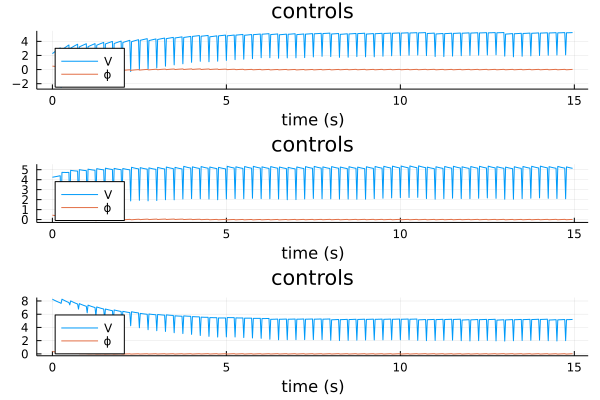

In [245]:
trefU = SA[0:dt:(Nc-2-1)*dt]
p = plot(layout=(3,1))
plot!(p[1], trefU, Ulinec1, inds=1:2, labels=["V" "ϕ"], legend=:bottomleft, title="controls", xlabel="time (s)")
plot!(p[2], trefU, Uline2, inds=1:2, labels=["V" "ϕ"], legend=:bottomleft, title="controls", xlabel="time (s)")
plot!(p[3], trefU, Uline3, inds=1:2, labels=["V" "ϕ"], legend=:bottomleft, title="controls", xlabel="time (s)")
# plot!(p[3], trefU, Uline3, inds=1:2, labels=["V" "ϕ"], legend=:bottomleft, title="controls", xlabel="time (s)")

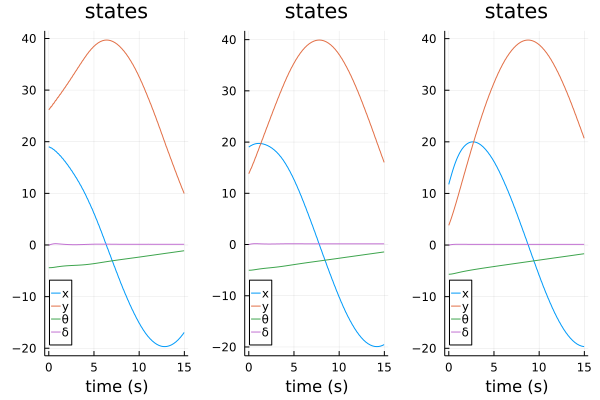

In [246]:
trefN = SA[0:dt:(Nc-1-1)*dt]
p = plot(layout=(1, 3))
plot!(p[1], trefN, Xlinec1, inds=1:4, labels=["x" "y" "θ" "δ"], legend=:bottomleft, title="states", xlabel="time (s)")
plot!(p[2], trefN, Xline2, inds=1:4, labels=["x" "y" "θ" "δ"], legend=:bottomleft, title="states", xlabel="time (s)")
plot!(p[3], trefN, Xline3, inds=1:4, labels=["x" "y" "θ" "δ"], legend=:bottomleft, title="states", xlabel="time (s)")
# plot!(p[3], trefU, Xline3, inds=1:4, labels=["x" "y" "θ" "δ"], legend=:bottomleft, title="states", xlabel="time (s)")

┌ Info: Saved animation to 
│   fn = /home/nambags/convoy_ws/src/tmp.gif
└ @ Plots /home/nambags/.julia/packages/Plots/8K4be/src/animation.jl:114


Plots.AnimatedGif("/home/nambags/convoy_ws/src/tmp.gif")
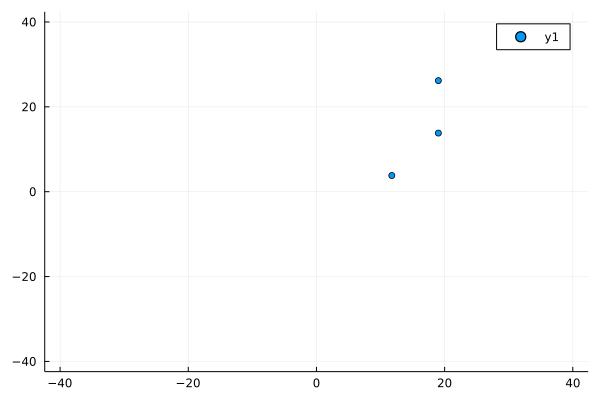

In [247]:
@gif for i = 1:Nc-1-1
    scatter([Xlinec1[i][1], Xline2[i][1], Xline3[i][1]], [Xlinec1[i][2], Xline2[i][2], Xline3[i][2]], xlim=[-40, 40], ylim=[-40,40])
end

In [20]:
function diff_dist(Xline1, Xline2, Xref)
    len_dist = length(Xline1)
    dist = zeros(len_dist)*NaN
    for i = 1:length(Xline1)
        idx1 = get_closest_index(Xline1[i], Xref)
        idx2 = get_closest_index(Xline2[i], Xref)
        dist[i] = idx2 - idx1
    end
    return dist
end

diff_dist (generic function with 1 method)

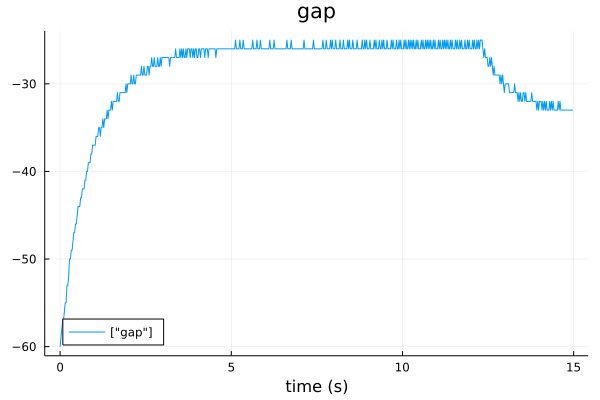

In [21]:
XDiff = diff_dist(Xline2, Xline3, Xref)
XDiff = [SVector{1}(XDiff[i]) for i = 1:length(XDiff)]
p = plot(layout=(1,1))
plot!(p[1], trefU, XDiff, labels=["gap"], legend=:bottomleft, title="gap", xlabel="time (s)")

In [ ]:
# Visualize in MeshCat
vis = initialize_visualizer(model)

In [44]:
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("chassis" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6f, 0x6d, 0x2f, 0x63, 0x68, 0x61, 0x73, 0x73, 0x69, 0x73], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("body" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x61, 0x73, 0x73, 0x69, 0x73, 0x2f, 0x62, 0x6f, 0x64, 0x79], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "wheel" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x73, 0x69, 0x73, 0x2f, 0x77, 0x68, 0x65, 0x65, 0x6c], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "front" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x66, 0x72, 0x6f, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("wheel" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x6e, 0x74, 0x2f, 0x77, 0x68, 0x65, 0x65, 0x6c], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))))))), Set(Any[WebSocket(server, CONNECTED)]), ip"127.0.0.1", 8701))

In [45]:
# send trajectory to the visualizer
visualize!(vis, model, (Nc-1)*dt, Xline1)

In [217]:
# display a new visualizer pane
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("chassis" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6f, 0x6d, 0x2f, 0x63, 0x68, 0x61, 0x73, 0x73, 0x69, 0x73], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("body" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x61, 0x73, 0x73, 0x69, 0x73, 0x2f, 0x62, 0x6f, 0x64, 0x79], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "wheel" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x73, 0x69, 0x73, 0x2f, 0x77, 0x68, 0x65, 0x65, 0x6c], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "front" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x66, 0x72, 0x6f, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("wheel" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x6e, 0x74, 0x2f, 0x77, 0x68, 0x65, 0x65, 0x6c], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))))))), Set(Any[WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED)]), ip"127.0.0.1", 8700))

In [301]:
# Send the trajectory to the visualizer
visualize!(vis, model, (Nc-1)*dt, Xref3)

In [317]:
# Xline,Uline,Kline,Pline, iterline = iLQR(Xref1[1],Uref1,Xref1,Uref);
# Xline,Uline,Kline,Pline, iterline = iLQR(Xref2[1],Uref2,Xref2,Uref);
Xline,Uline,Kline,Pline, iterline = iLQR(Xref3[1],Uref3,Xref3,Uref);

LoadError: BoundsError: attempt to access 20-element Vector{SVector{4, Float64}} at index [21]

In [17]:
Xline, Uline = ilqr_mpc(Xref, Uref, 1, Q, R, Qf, Nhz, Nmpc, Nc);

In [18]:
Xline = [SVector{4}(Xline[i]) for i = 1:length(Xline)]
Uline = [SVector{2}(Uline[i]) for i = 1:length(Uline)];

In [131]:
savefig("/home/nambags/convoy_ws/gap12")